In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
from tqdm import tqdm as tqdm

In [14]:
import matplotlib.pyplot as plt

In [5]:
class CAE(nn.Module):
    def __init__(self, 
                 img_channel = 1,
                 kernel_size = 4,
                 latent_dim = 16,
                 init_channels = 8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channel, out_channels=init_channels, 
                      kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=1),
            nn.Conv2d(in_channels=img_channel, out_channels=init_channels*2, 
                      kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=1),
            nn.Conv2d(in_channels=img_channel*2, out_channels=init_channels*4, 
                      kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2, stride=2, padding=1),
            nn.Conv2d(in_channels=img_channel*4, out_channels=64, 
                      kernel_size=2, stride=1, padding=0),
        )
        
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size = 3, stride=1, padding=1),
            nn.ConvTranspose2d(16, 8,  kernel_size = 3, stride=1, padding=1),
            nn.ConvTranspose2d(8,  3,  kernel_size = 2, stride=1, padding=1),
        )
        
    
    def decoding(self, x):
        decoded_x = self.decoder(x)
        print(f"decoded_x.shape : {decoded_x.shape}")
        
        return decoded_x
    
    def encoding(self, x):
        encoded_x = self.encoder(x)
        print(f"encoded_x.shape : {encoded_x.shape}")
        
        return encoded_x
    
    def forward(self, x):
        encoded_x = self.encoding(x)
        output = self.decoding(encoded_x)
        return output

In [12]:
model = CAE()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
model.to(device)

In [16]:
epochs = 5
steps = 0
running_loss = 0
for epoch in range(epochs):
    model.train()
    
    for _, (img, target) in tqdm(enumerate(train_dataloader)):
        img = img.to(device)
        output = model(img)
        loss = loss_function(output, img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * img.shape[0]
        break
    break

0it [00:00, ?it/s]

encoded_x.shape : torch.Size([1, 32, 430, 643])
decoded_x.shape : torch.Size([1, 3, 3432, 5136])


0it [09:55, ?it/s]


KeyboardInterrupt: 

In [3]:
class cocoDataset(Dataset):
    def __init__(self, img_path, annotation):
        self.coco = datasets.CocoDetection(img_path, annotation)
        self.totensor = transforms.ToTensor()
    
    def __getitem__(self, idx):
        img, target = self.coco[idx]
        tensor_img = self.totensor(img)
        
        return tensor_img, target
    
    def __len__(self):
        return len(self.coco)

In [88]:
coco = cocoDataset(img_path='/home/jetson/val2017/val2017', annotation='/home/jetson/val2017/annotations/stuff_val2017.json')

loading annotations into memory...
Done (t=1.73s)
creating index...
index created!


In [89]:
len(coco)

5000

In [80]:
img_tensor, tar = coco[1]

In [82]:
img_tensor1, tar = coco[0]

In [83]:
img_tensor1.shape  ## conv o = (i + 2p -k) / s + 1

torch.Size([3, 426, 640])

480 640

In [81]:
img_tensor.shape

torch.Size([3, 640, 586])

In [17]:
tar[0]['bbox']

[0.0, 38.0, 549.0, 297.0]

In [75]:
pil_img = transforms.functional.to_pil_image(img_tensor)

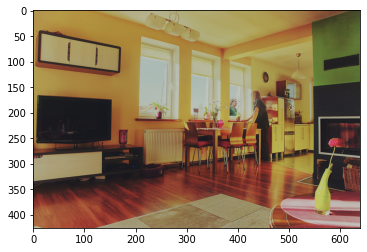

In [76]:
plt.imshow(pil_img)

In [70]:
np_img = img_tensor.numpy() * 255

In [12]:
np_img = np_img.astype(np.uint8).copy()

In [32]:
np_img.shape

array([[[170., 173., 175., ...,  69.,  68.,  70.],
        [172., 176., 177., ...,  69.,  72.,  71.],
        [175., 177., 178., ...,  70.,  69.,  71.],
        ...,
        [188., 183., 193., ..., 186., 186., 187.],
        [186., 187., 186., ..., 198., 195., 186.],
        [186., 187., 186., ..., 129., 126., 107.]],

       [[136., 142., 144., ...,  76.,  76.,  71.],
        [141., 145., 146., ...,  77.,  80.,  75.],
        [144., 146., 147., ...,  78.,  77.,  75.],
        ...,
        [189., 183., 187., ..., 157., 157., 156.],
        [183., 184., 183., ..., 134., 120.,  88.],
        [183., 184., 183., ...,  60.,  57.,  41.]],

       [[ 73.,  77.,  79., ...,  42.,  39.,  37.],
        [ 77.,  80.,  81., ...,  40.,  43.,  40.],
        [ 79.,  81.,  80., ...,  39.,  40.,  40.],
        ...,
        [157., 149., 153., ..., 153., 153., 154.],
        [152., 153., 152., ..., 134., 124., 101.],
        [150., 151., 152., ...,  63.,  60.,  45.]]], dtype=float32)

In [36]:
np_img[0].shape

(426, 640)

In [48]:
for i in tar:
    bb = i['bbox']
    x, y, h, w = [int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3])]
    for j in range(3):
        np_img[j][y][x:x+h] = 255
        np_img[j][y+w][x:x+h] = 255
        for k in range(w):
            np_img[j][y+w][x] = 255
            np_img[j][y+w][x+h] = 255
    break

In [50]:
np_img

array([[[170., 173., 175., ...,  69.,  68.,  70.],
        [172., 176., 177., ...,  69.,  72.,  71.],
        [175., 177., 178., ...,  70.,  69.,  71.],
        ...,
        [188., 183., 193., ..., 186., 186., 187.],
        [186., 187., 186., ..., 198., 195., 186.],
        [186., 187., 186., ..., 129., 126., 107.]],

       [[136., 142., 144., ...,  76.,  76.,  71.],
        [141., 145., 146., ...,  77.,  80.,  75.],
        [144., 146., 147., ...,  78.,  77.,  75.],
        ...,
        [189., 183., 187., ..., 157., 157., 156.],
        [183., 184., 183., ..., 134., 120.,  88.],
        [183., 184., 183., ...,  60.,  57.,  41.]],

       [[ 73.,  77.,  79., ...,  42.,  39.,  37.],
        [ 77.,  80.,  81., ...,  40.,  43.,  40.],
        [ 79.,  81.,  80., ...,  39.,  40.,  40.],
        ...,
        [157., 149., 153., ..., 153., 153., 154.],
        [152., 153., 152., ..., 134., 124., 101.],
        [150., 151., 152., ...,  63.,  60.,  45.]]], dtype=float32)

In [41]:
from PIL import Image
from matplotlib import cm

In [52]:
import cv2

In [73]:
img = np.ascontiguousarray(np_img.transpose(1, 2, 0))
img = Image.fromarray(img, 'RGB')

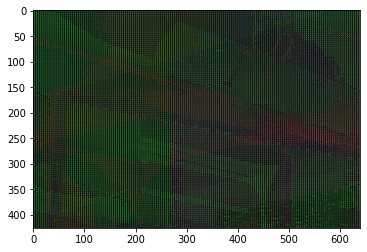

In [74]:
plt.imshow(img)

In [34]:
for i in tar:
    print(i['bbox'])

[0.0, 38.0, 549.0, 297.0]
[136.0, 0.0, 473.0, 116.0]
[444.0, 226.0, 20.0, 11.0]
[0.0, 269.0, 564.0, 157.0]
[338.0, 166.0, 29.0, 50.0]
[292.0, 246.0, 348.0, 111.0]
[212.0, 11.0, 321.0, 127.0]
[216.0, 233.0, 81.0, 70.0]
[564.0, 282.0, 35.0, 47.0]
[135.0, 359.0, 336.0, 67.0]
[129.0, 168.0, 351.0, 162.0]
[457.0, 350.0, 183.0, 76.0]
[0.0, 0.0, 640.0, 358.0]
[204.0, 63.0, 234.0, 174.0]
[7.0, 121.0, 632.0, 278.0]


In [16]:
train_size = int(len(coco) * 0.8)
valid_size = len(coco) - train_size

In [9]:
train_data, valid_data = random_split(coco, [train_size, valid_size])

In [10]:
len(train_data)

4000

In [11]:
train_dataloader = DataLoader(train_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

In [68]:
m_h = 700
m_w = 700
for i in range(len(coco)):
    img, _ = coco[i]
    if img.shape[1] < m_h:
        m_h = img.shape[1]
    if img.shape[2] < m_w:
        m_w = img.shape[2]
print(m_h, m_w)

145 200


In [ ]:
"""
# issues
1. img의 크기가 제각기 다르다.--> img를 conv / transconv 하는 과정에서 어쩔 수 없이 크기가 다른 이미지가 생성됨.
2. 파이썬 버전 때문에 cocodetection을 어떻게 사용해야할지 모르겠음 －＞ segmentation -> 이미 segmentation 된 이미지를 사용
"""

In [5]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1)
        )
        
        self.fc1 = nn.Linear(32, 128)
        self.fc_mu = nn.Linear(128, 16)
        self.fc_log_var = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 32)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride=1, padding=1),
            nn.ConvTranspose2d(16, 8,  kernel_size = 3, stride=1, padding=1),
            nn.ConvTranspose2d(8,  3,  kernel_size = 2, stride=1, padding=1),
        )
        
    
    def decoding(self, x):
        decoded_x = self.decoder(x)
        print(f"decoded_x.shape : {decoded_x.shape}")
        
        return decoded_x
    
    def encoding(self, x):
        encoded_x = self.encoder(x)
        print(f"encoded_x.shape : {encoded_x.shape}")
        
        return encoded_x
    
    def forward(self, x):
        encoded_x = self.encoding(x)
        output = self.decoding(encoded_x)
        return output

In [12]:
model = CAE()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [14]:
model.to(device)

CAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): ConvTranspose2d(8, 3, kernel_size=(2, 2

In [16]:
epochs = 5
steps = 0
running_loss = 0
for epoch in range(epochs):
    model.train()
    
    for _, (img, target) in tqdm(enumerate(train_dataloader)):
        img = img.to(device)
        output = model(img)
        loss = loss_function(output, img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * img.shape[0]
        break
    break

0it [00:00, ?it/s]

encoded_x.shape : torch.Size([1, 32, 430, 643])
decoded_x.shape : torch.Size([1, 3, 3432, 5136])


0it [09:55, ?it/s]


KeyboardInterrupt: 